In [112]:
import os
import pandas as pd
import plotly as pt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from plotly_calplot import calplot
from pathlib import Path

project_root = Path(os.getcwd()).resolve().parent
merged_data_dir = project_root / "data" / "merged"
dataset = pd.read_csv(f"{merged_data_dir}/combined_cleaned_dataset.csv",encoding='cp1250', sep=",")

# pickup_destination_data = pd.DataFrame()

# pickup_destination_data.insert(0, 'begintrip_lat', dataset.pop('begintrip_lat'))
# pickup_destination_data.insert(1, 'begintrip_lng', dataset.pop('begintrip_lng'))
# pickup_destination_data.insert(2, 'dropoff_lat', dataset.pop('dropoff_lat'))
# pickup_destination_data.insert(3, 'dropoff_lng', dataset.pop('dropoff_lng'))


df_counts = dataset.groupby(['product_type_name', 'license_plate']).size().reset_index(name='count')
df_counts_sorted = df_counts.sort_values(by='count', ascending=False)
fig = px.bar(df_counts_sorted, 
             y='license_plate', 
             x='count', 
             color='product_type_name', 
             title="ile kazde auto przejezdzilo kategorii",
             labels={'product_type_name': 'Category', 'license_plate': 'Group'},
             hover_data=['product_type_name', 'license_plate', 'count'])

fig.show()


dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20967 entries, 0 to 20966
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   begintrip_timestamp_local      20967 non-null  object 
 1   credits_local                  20967 non-null  float64
 2   dropoff_lat                    14521 non-null  float64
 3   per_minute_fare_local          20967 non-null  float64
 4   is_cash_trip                   20967 non-null  bool   
 5   license_plate                  20967 non-null  object 
 6   service_fee                    20967 non-null  float64
 7   dropoff_lng                    14521 non-null  float64
 8   dropoff_timestamp_local        20967 non-null  object 
 9   driver_id                      20967 non-null  int64  
 10  service_fee_local              20967 non-null  float64
 11  begintrip_lat                  14521 non-null  float64
 12  request_timestamp_local        20967 non-null 

In [113]:

dataset['begintrip_timestamp_local'] = pd.to_datetime(dataset['begintrip_timestamp_local'],format='mixed')
dataset['date'] = dataset['begintrip_timestamp_local'].dt.date 
dataset['year'] = dataset['begintrip_timestamp_local'].dt.year
dataset['month'] = dataset['begintrip_timestamp_local'].dt.month

date_counts = dataset.groupby('date').size().reset_index(name='count')
print(date_counts)

           date  count
0    2022-07-22     10
1    2022-07-23     18
2    2022-07-24     18
3    2022-07-26     11
4    2022-07-27     32
..          ...    ...
830  2025-04-17     10
831  2025-04-19      1
832  2025-04-20      1
833  2025-04-21      2
834  2025-04-22      3

[835 rows x 2 columns]


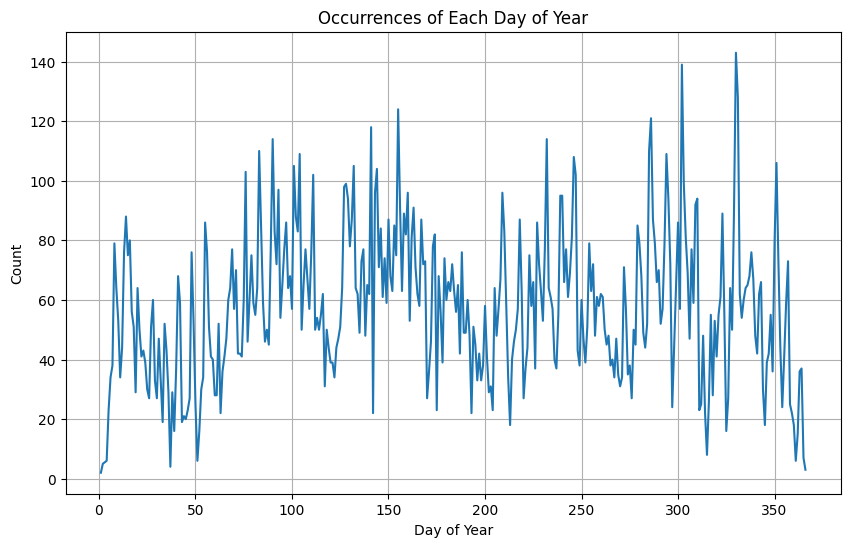

In [114]:
dataset['begintrip_timestamp_local'] = pd.to_datetime(dataset['begintrip_timestamp_local'], format='mixed')

# Step 2: Extract the day of the year (1 to 366)
dataset['day_of_year'] = dataset['begintrip_timestamp_local'].dt.day_of_year

# Step 3: Group by 'day_of_year' and count occurrences
day_of_year_counts = dataset.groupby('day_of_year').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.plot(day_of_year_counts['day_of_year'], day_of_year_counts['count'])
plt.title('Occurrences of Each Day of Year')
plt.xlabel('Day of Year')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [115]:
dataset['begintrip_timestamp_local'] = pd.to_datetime(dataset['begintrip_timestamp_local'])
dataset['day_of_year'] = dataset['begintrip_timestamp_local'].dt.day_of_year

dataset = dataset.dropna(subset=['day_of_year'])
dataset['day_of_year'] = dataset['day_of_year'].astype(int)

day_of_year_counts = dataset.groupby('day_of_year').size().reset_index(name='count')

reference_year = 2025
day_of_year_counts['date'] = pd.to_datetime(day_of_year_counts['day_of_year'].astype(str), format='%j')

day_of_year_counts['date'] = day_of_year_counts['date'].apply(lambda x: x.replace(year=reference_year))


fig = calplot(
    day_of_year_counts,  
    x='date',            
    y='count',
    title="Heatmapa kazdego dnia w roku",
    colorscale='BuPu'
)

fig.update_layout(
    height=400,
    font=dict(family='Arial', size=14, color='black'))
fig.show()


In [116]:
month_mean_trip_costs = dataset.groupby(dataset.begintrip_timestamp_local.dt.to_period('M'))['driver_upfront_fare_local'].mean().reset_index(name='Monthly Mean')
month_mean_trip_costs = month_mean_trip_costs.sort_values(by='begintrip_timestamp_local', ascending=True)
month_mean_trip_costs['begintrip_timestamp_local'] = month_mean_trip_costs['begintrip_timestamp_local'].dt.strftime('%b %Y')

fig = px.line(data_frame=month_mean_trip_costs,x='begintrip_timestamp_local',y="Monthly Mean",title="Mediana cen kursów w danych miesiącach")
fig.update_traces(line_color='#000000')
fig.update_layout(height=500, font=dict(family='Arial', size=14, color='black'))
fig.show()


In [117]:
grouped = dataset.groupby(dataset.begintrip_timestamp_local.dt.to_period('M'))

month_avg_earnings = grouped['driver_upfront_fare_local'].sum() / grouped['driver_id'].nunique()
month_avg_earnings = month_avg_earnings.reset_index(name='Monthly Average')
month_avg_earnings = month_avg_earnings.sort_values(by='begintrip_timestamp_local', ascending=True)
month_avg_earnings['begintrip_timestamp_local'] = month_avg_earnings['begintrip_timestamp_local'].dt.strftime('%b %Y')

fig = px.line(
    data_frame=month_avg_earnings,
    x='begintrip_timestamp_local',
    y="Monthly Average",
    title="Suma zarobków za kazdy miesiac, wyważona przez ilość kierowców")

fig.update_traces(line_color='#000000')
fig.update_layout(height=500, font=dict(family='Arial', size=14, color='black'),plot_bgcolor="#999999")
fig.show()


In [118]:
import plotly.io as pio

grouped = dataset.groupby(["begintrip_lat", "begintrip_lng"]).size().reset_index(name="count")
grouped['size'] = 50
grouped['count_impr'] = np.sqrt(grouped['count'].astype(float))

fig = px.scatter_mapbox(
    data_frame=grouped,
    lat="begintrip_lat",
    lon="begintrip_lng",
    color="count_impr",
    size="size",
    opacity=1,
    zoom=10,
    hover_data="count",
    mapbox_style='carto-darkmatter'
)

fig.update_layout(
    height=1000,
    font=dict(family='Arial', size=14, color='black'),
    legend_visible=False
)

pio.show(fig, config={"scrollZoom": True})




In [119]:
import plotly.io as pio

grouped = dataset.groupby(["dropoff_lat", "dropoff_lng"]).size().reset_index(name="count")
grouped['size'] = 50
grouped['count_impr'] = np.sqrt(grouped['count'].astype(float))

fig = px.scatter_mapbox(
    data_frame=grouped,
    lat="dropoff_lat",
    lon="dropoff_lng",
    color="count_impr",
    size="size",
    opacity=1,
    zoom=10,
    hover_data="count",
    mapbox_style='carto-darkmatter'
)

fig.update_layout(
    height=1000,
    font=dict(family='Arial', size=14, color='black'),
    legend_visible=False
)

pio.show(fig, config={"scrollZoom": True})




In [120]:
grouped = dataset.groupby(["begintrip_lat", "begintrip_lng"]).size().reset_index(name="count")
grouped['size'] = 50
grouped['count_impr'] = np.sqrt(grouped['count'].astype(float))

fig = px.density_map(
    data_frame=grouped,
    lat="begintrip_lat",
    lon="begintrip_lng",
    z="count_impr",
    opacity=1,
    zoom=11,
    radius=130,
    custom_data="count"
)

fig.update_layout(
    mapbox_style="open-street-map",
    height=1000,
    font=dict(family='Arial', size=14, color='black'),
)

fig.update_traces(
    hovertemplate=(
        'Latitude: %{lat}<br>'
        'Longitude: %{lon}<br>'        
        'Amount of trips to this destination: %{customdata[0]}<extra></extra>'
    )
)

pio.show(fig, config={"scrollZoom": True})


In [121]:
grouped = dataset.groupby(["dropoff_lat", "dropoff_lng"]).size().reset_index(name="count")
grouped['count_impr'] = np.sqrt(grouped['count'].astype(float))

fig = px.density_map(
    data_frame=grouped,
    lat="dropoff_lat",
    lon="dropoff_lng",
    z="count_impr",
    opacity=1,
    zoom=10,
    radius=130,
    custom_data="count"
)

fig.update_layout(
    mapbox_style="open-street-map",
    height=1000,
    font=dict(family='Arial', size=14, color='black'),
)

fig.update_traces(
    hovertemplate=(
        'Latitude: %{lat}<br>'
        'Longitude: %{lon}<br>'        
        'Amount of trips to this destination: %{customdata[0]}<extra></extra>'
    )
)

pio.show(fig, config={"scrollZoom": True})


In [137]:
dataset['trip_distance_km'] = dataset['trip_distance_miles'] * 1.60934


longest_trips = pd.DataFrame({
    'trip_reward': dataset['driver_upfront_fare_local'],
    'distance in km': dataset['trip_distance_km'],
    'duration in min' : dataset['trip_duration_seconds']/60
})

longest_trips = longest_trips.sort_values(by='distance in km', ascending=False)
# longest_trips = longest_trips.head(15)

fig = px.scatter(longest_trips, y='distance in km', x='duration in min',custom_data="trip_reward")
fig.update_layout(title='Highest Values', margin=dict(l=40, r=20, t=40, b=40),)

fig.update_traces(
    hovertemplate=(
        'distance in km: %{y}<br>'
        'duration in min: %{x}<br>'        
        'reward: %{customdata[0]}<extra></extra>'
    )
)

fig.show()